### Librerias

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, fbeta_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from pathlib import Path

### Carga de datos

In [84]:
df = pd.read_csv('../data/processed/final_dataset.csv')

### Division del dataset (train - test)

In [85]:
X = df.drop(columns=['nicotine', 'nicotine_label', 'target'])  
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

### Procesamiento de Datos

#### Generacion de variable para la calidad del dato

In [86]:
# Debido a la presencia de nulos, se establece una suerte de "indice de calidad" del registro. Se imputa con la mediana

def preprocess_data(X_train, X_test):
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()

    nan_cols = X_train.columns[X_train.isna().any()].tolist()


    for col in nan_cols:
        X_train_clean[f"{col}_missing"] = X_train_clean[col].isna().astype(int)
        X_test_clean[f"{col}_missing"] = X_test_clean[col].isna().astype(int)


    imputer = SimpleImputer(strategy='median')
    X_train_clean[nan_cols] = imputer.fit_transform(X_train_clean[nan_cols])
    X_test_clean[nan_cols] = imputer.transform(X_test_clean[nan_cols])


    X_train_clean["missing_rate"] = X_train_clean[[f"{c}_missing" for c in nan_cols]].mean(axis=1)
    X_test_clean["missing_rate"] = X_test_clean[[f"{c}_missing" for c in nan_cols]].mean(axis=1)

    return X_train_clean, X_test_clean

#### Optimizacion del threshold (para amortiguar el desbalanceo de clases)

In [87]:
def find_best_threshold(y_true, y_probs, beta=2.0):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-9)
    best_idx = np.nanargmax(f_beta)
    return thresholds[best_idx], f_beta[best_idx]


#### Optimizacion LightGBM

In [88]:
def objective_lgb(trial, X, y):
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 30),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 15.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 15.0, log=True),
        'random_state': 42,
        'early_stopping_rounds': 30,
        'verbose_eval': False
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for tr_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        # Aplicar SMOTE SOLO al train en cada fold
        X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        dtr = lgb.Dataset(X_tr, label=y_tr)
        dval = lgb.Dataset(X_val, label=y_val)
        model = lgb.train(params, dtr, valid_sets=[dval])
        preds = model.predict(X_val)
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

#### Optimizacion de XGBoost

In [89]:
def objective_xgb(trial, X, y):
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-0, log=True),
        'max_depth': trial.suggest_int("max_depth", 3, 20),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 50),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'lambda': trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float("alpha", 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_estimators': 1000,
        'early_stopping_rounds': 30
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for tr_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        # Aplicar SMOTE SOLO al train en cada fold
        X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

#### Pipeline Principal

In [90]:
def main_pipeline(X_train, X_test, y_train, y_test):
    # Preprocesamiento de los datos
    X_train_clean, X_test_clean = preprocess_data(X_train, X_test)

    # Optimización LightGBM
    print("Optimizing LightGBM...")
    study_lgb = optuna.create_study(direction='maximize')
    study_lgb.optimize(lambda trial: objective_lgb(trial, X_train_clean, y_train), n_trials=50)
    best_lgb = study_lgb.best_params
    best_lgb.update({
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    })
    final_lgb = lgb.LGBMClassifier(**best_lgb)
    final_lgb.fit(X_train_clean, y_train)

    # Optimización XGBoost
    print("Optimizing XGBoost...")
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(lambda trial: objective_xgb(trial, X_train_clean, y_train), n_trials=50)
    best_xgb = study_xgb.best_params
    best_xgb.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    })
    final_xgb = xgb.XGBClassifier(**best_xgb)
    final_xgb.fit(X_train_clean, y_train)

    # Ensambles: Stacking y Voting
    stack = StackingClassifier(
        estimators=[('lgb', final_lgb), ('xgb', final_xgb)],
        final_estimator=LogisticRegression(max_iter=1000),
        passthrough=True
    )
    stack.fit(X_train_clean, y_train)

    vote = VotingClassifier(
        estimators=[('lgb', final_lgb), ('xgb', final_xgb)],
        voting='soft'
    )
    vote.fit(X_train_clean, y_train)

    # Crear diccionario de modelos
    models = {
        "LightGBM": final_lgb,
        "XGBoost": final_xgb,
        "Stacking": stack,
        "Voting": vote
    }

    return models, X_train_clean, X_test_clean

#### Evaluacion de la optimizacion de hiperpatametros - LightGBM

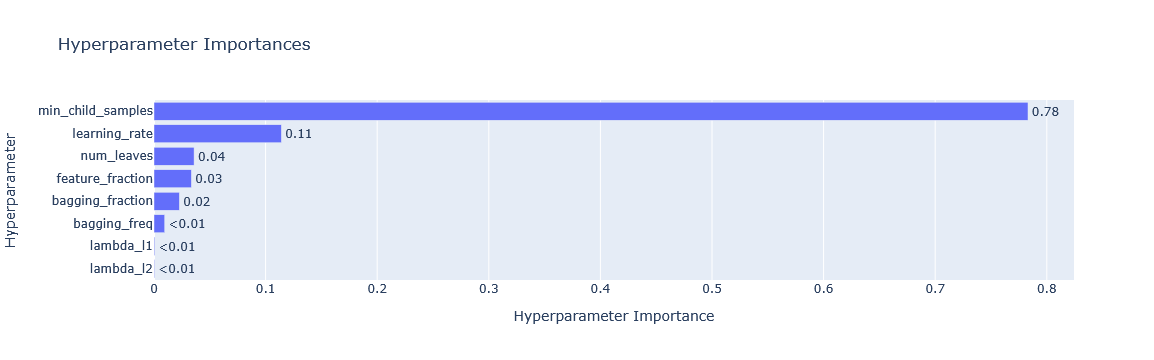

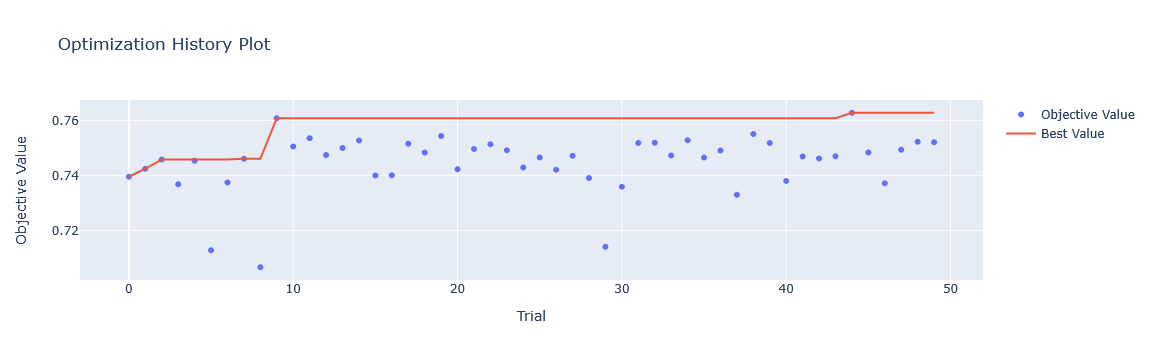

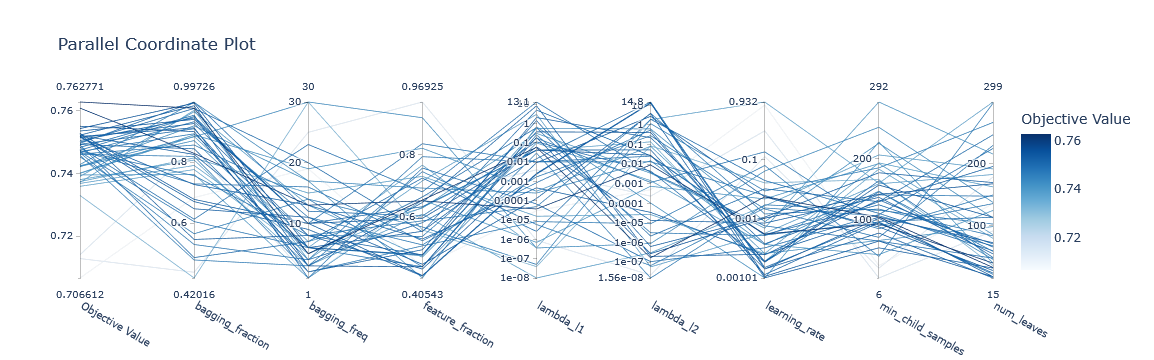

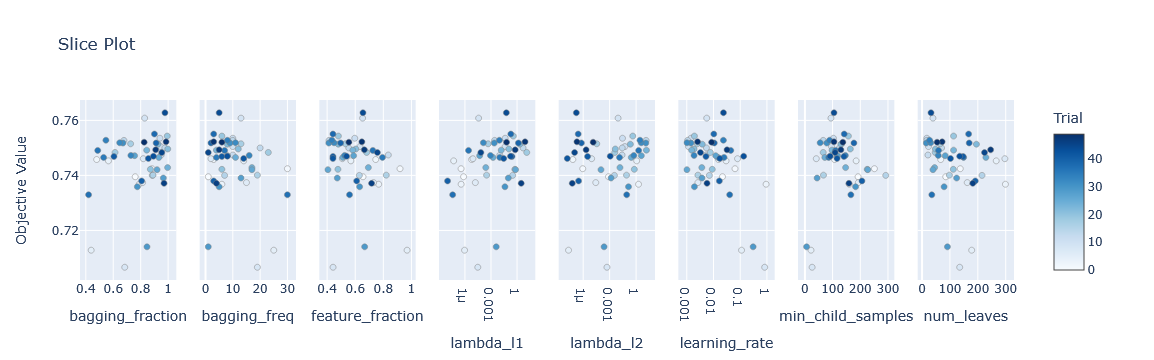

In [91]:
optuna.visualization.plot_param_importances(study_lgb).show()
optuna.visualization.plot_optimization_history(study_lgb).show()
optuna.visualization.plot_parallel_coordinate(study_lgb).show()
optuna.visualization.plot_slice(study_lgb).show()

####  Evaluacion de la optimizacion de hiperpatametros - XGBoost

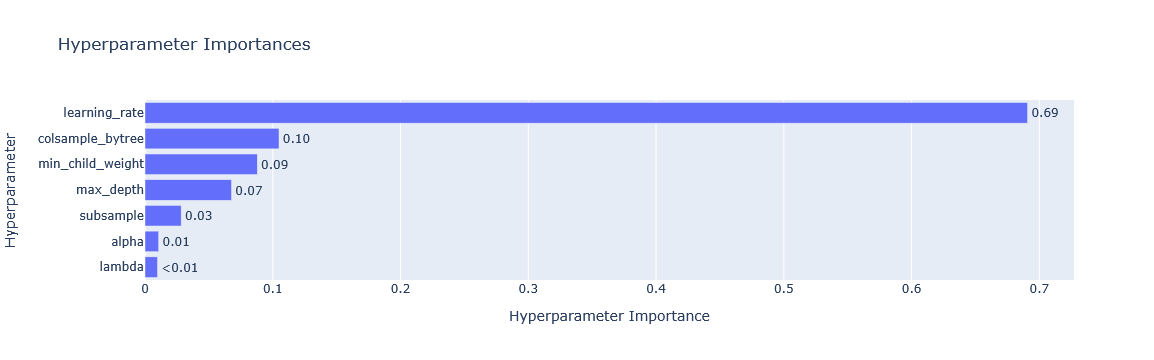

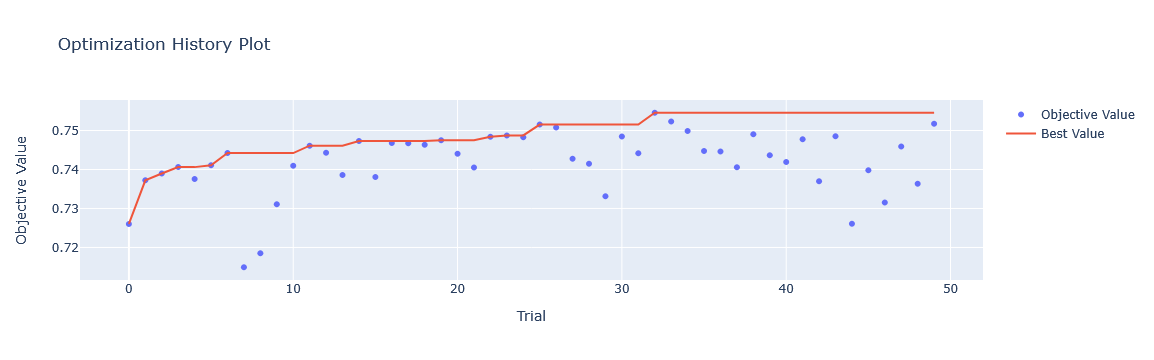

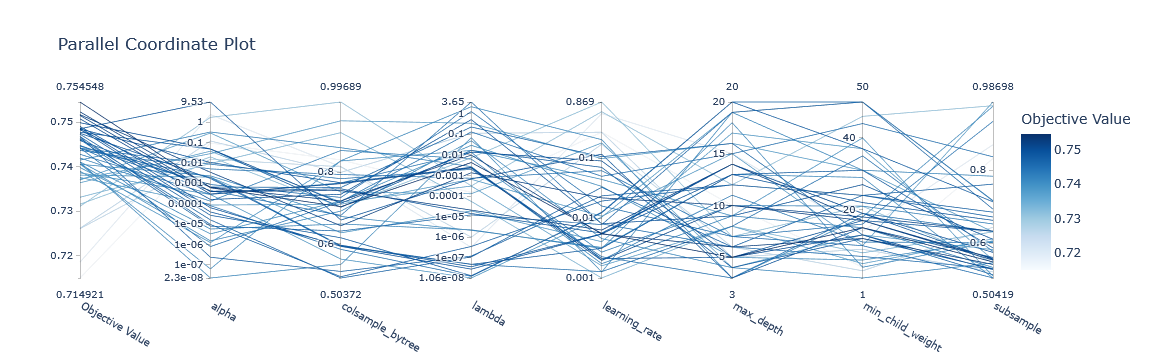

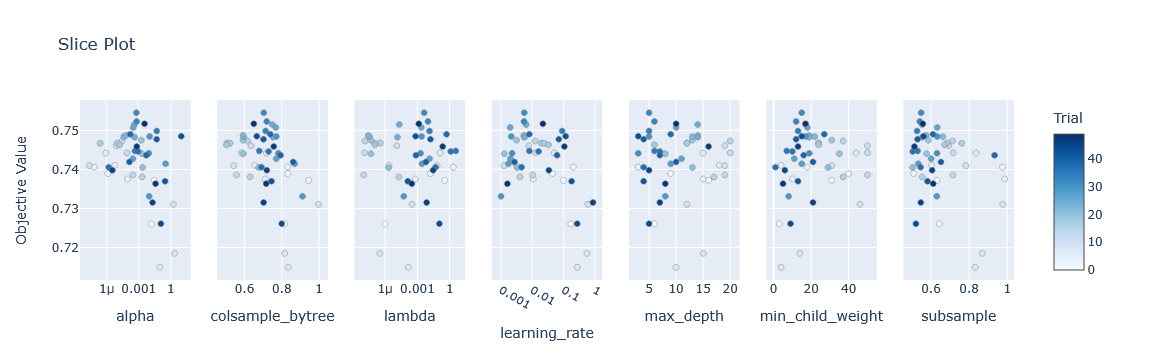

In [92]:
optuna.visualization.plot_param_importances(study_xgb).show()
optuna.visualization.plot_optimization_history(study_xgb).show()
optuna.visualization.plot_parallel_coordinate(study_xgb).show()
optuna.visualization.plot_slice(study_xgb).show()

In [95]:
models, X_train_clean, X_test_clean = main_pipeline(X_train, X_test, y_train, y_test)

Path("models").mkdir(exist_ok=True)

joblib.dump(X_train_clean, "../models/X_train_clean.pkl")
joblib.dump(X_test_clean, "../models/X_test_clean.pkl")


for name, model in models.items():
    joblib.dump(model, f"../models/final_{name.lower()}.pkl")

[I 2025-07-03 19:25:39,576] A new study created in memory with name: no-name-ec9dd7fc-aad1-499f-973b-fd329858b0ed


Optimizing LightGBM...


[I 2025-07-03 19:25:39,990] Trial 0 finished with value: 0.7493059660645868 and parameters: {'learning_rate': 0.08651906512827359, 'num_leaves': 66, 'min_child_samples': 134, 'feature_fraction': 0.45599584802653353, 'bagging_fraction': 0.6851125114121269, 'bagging_freq': 23, 'lambda_l1': 0.001611816196172177, 'lambda_l2': 0.9345356343050778}. Best is trial 0 with value: 0.7493059660645868.
[I 2025-07-03 19:25:41,132] Trial 1 finished with value: 0.7159012041598248 and parameters: {'learning_rate': 0.014628267240836787, 'num_leaves': 292, 'min_child_samples': 29, 'feature_fraction': 0.8796278970151844, 'bagging_fraction': 0.9169156898749989, 'bagging_freq': 30, 'lambda_l1': 6.008271737955625e-08, 'lambda_l2': 9.186960295116007e-05}. Best is trial 0 with value: 0.7493059660645868.
[I 2025-07-03 19:25:41,473] Trial 2 finished with value: 0.7403357963875206 and parameters: {'learning_rate': 0.27496529967038386, 'num_leaves': 289, 'min_child_samples': 129, 'feature_fraction': 0.955815981206

Optimizing XGBoost...


[I 2025-07-03 19:26:09,557] Trial 0 finished with value: 0.7298661056376574 and parameters: {'learning_rate': 0.007218188737846037, 'max_depth': 4, 'min_child_weight': 16, 'subsample': 0.5667329483353458, 'colsample_bytree': 0.5017961833730702, 'lambda': 8.137555867474346e-07, 'alpha': 9.711940204706845}. Best is trial 0 with value: 0.7298661056376574.
[I 2025-07-03 19:26:10,487] Trial 1 finished with value: 0.742342227695676 and parameters: {'learning_rate': 0.04521139983425436, 'max_depth': 12, 'min_child_weight': 44, 'subsample': 0.5679925849092504, 'colsample_bytree': 0.7847744935621135, 'lambda': 0.00013534393922960352, 'alpha': 7.598812204749106e-07}. Best is trial 1 with value: 0.742342227695676.
[I 2025-07-03 19:26:11,235] Trial 2 finished with value: 0.7341906130268199 and parameters: {'learning_rate': 0.24185818318416716, 'max_depth': 16, 'min_child_weight': 41, 'subsample': 0.7654081806881712, 'colsample_bytree': 0.51657098712143, 'lambda': 3.665288378093568e-08, 'alpha': 1.